In [1]:

import numpy as np

            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
k = np.array([[ 1,  0,  0,  0,  0,  0,  1,  0,  0], # m1
              [ 1,  0,  0,  0,  0,  0,  0,  1,  0], # m2
              [ 1,  0,  0,  0,  0,  0,  0,  0,  1], # m3
              [ 0,  1,  0,  0,  0,  0,  1,  0,  0], # m4
              [ 0,  1,  0,  0,  0,  0,  0,  1,  0], # m5
              [ 0,  1,  0,  0,  0,  0,  0,  0,  1], # m6
              [ 0,  0,  1,  0,  0,  0,  1,  0,  0], # m7
              [ 0,  0,  1,  0,  0,  0,  0,  1,  0], # m8
              [ 0,  0,  1,  0,  0,  0,  0,  0,  1], # m9
              [ 0,  0,  0,  1,  0,  0,  1,  0,  0], # m10
              [ 0,  0,  0,  1,  0,  0,  0,  1,  0], # m11
              [ 0,  0,  0,  1,  0,  0,  0,  0,  1], # m12
              [ 0,  0,  0,  0,  1,  0,  1,  0,  0], # m13
              [ 0,  0,  0,  0,  1,  0,  0,  1,  0], # m14
              [ 0,  0,  0,  0,  1,  0,  0,  0,  1], # m15
              [ 0,  0,  0,  0,  0,  1,  1,  0,  0], # m16
              [ 0,  0,  0,  0,  0,  1,  0,  1,  0], # m17
              [ 0,  0,  0,  0,  0,  1,  0,  0,  1]]) # m18


def random_binary_array(shape, probability_of_one=0.5):
    # Ensure p is between 0 and 1
    if not 0 <= probability_of_one <= 1:
        raise ValueError("Probability p must be between 0 and 1.")
    choices = [0, 1]
    probabilities = [1-probability_of_one, probability_of_one]
    # Generate the random array with the specified probabilities
    random_array = np.random.choice(choices, size=shape, p=probabilities)
    return random_array


########################## test ########################################
# Example usage
# shape = (18)  # Specify the desired shape of the array
# probability_of_one = 0.9  # Probability of 1 in the array

# # Generate the array
# random_array = random_binary_array(shape = shape,probability_of_one = probability_of_one)
# print(random_array)
#########################################################################


In [2]:

# based on closed form expression
def validate_slow(k,p,q):
    m_nr,t_nr = k.shape
    A = np.zeros(m_nr)
    for msg in range(m_nr):
        for t in range(t_nr):
            temp = 1
            for m in range(m_nr):
                temp *= k[m,t]*p[m] + 0**(k[m,t])
            A[msg] += k[msg,t]*q[t]*temp
    return A

# based on mask and multiply operation
def validate(k,m,t,rectified = False, includeValidTag = False):
    # mask and multiply
    m_nr,t_nr = k.shape
    mm = np.zeros(t_nr)
    for tag in range(t_nr):
        mask = m[np.where(k[:,tag] == 1)] # mask for tag
        mm[tag] = np.prod(mask) # multiply the mask
    A = np.matmul(k,(mm*t).transpose())

    A = np.array( [1 if x > 1 else x for x in A]) if rectified else A
    return (A, mm*t) if includeValidTag else A

def Latency(k,m,t,lost_penalty = 40):
    m_nr,t_nr = k.shape
    A,validTags = validate(k,m,t,includeValidTag=True)
    L = [np.where(k[:,np.where((k[msg,:]*validTags)>0)[0][0]] == 1)[0][-1]-msg if A[msg] >0 else lost_penalty for msg in range(m_nr)]

    return np.array(L)


def reward(k,m,t,rectified_A = True, lost_penalty = 40, a = 1,l = 1, o = 100):
    m_nr,t_nr = k.shape
    A = validate(k,m,t,rectified=rectified_A)
    L= Latency(k,A,t,lost_penalty=lost_penalty)

    # # not considering the delay because of the lost or modified messages
    # A[m==0] = 1
    # L[m==0] = 0

    r = a*np.sum(A) - l*np.sum(L) - o * t_nr/m_nr

    return A, L, r

######### test #########
m_nr,t_nr = k.shape
probability_of_success_message = .9
probability_of_success_tag = 1
m = random_binary_array(shape = m_nr, probability_of_one = probability_of_success_message)
t = random_binary_array(shape = t_nr, probability_of_one = probability_of_success_tag)

A = validate(k,m,t)

print("m = ")
print(m.reshape(6,-1))

print("t = ")
print(t)

print("A = ")
print(np.int8(A).reshape(6,-1))

print("Latency = ")
print(Latency(k,m,t))

print("reward = ")
print(reward(k,m,t, rectified_A = False, lost_penalty = 40, a = 1,l = 0, o = 0)[2])

m = 
[[1 1 1]
 [1 1 1]
 [1 0 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]
t = 
[1 1 1 1 1 1 1 1 1]
A = 
[[2 1 2]
 [2 1 2]
 [1 0 1]
 [2 1 2]
 [2 1 2]
 [2 1 2]]
Latency = 
[ 2  1  0  2  1  0  9 40  9  2  1  0  2  1  0  2  1  0]
reward = 
27.0


In [49]:
m_nr,t_nr = k.shape
probability_of_success_message = .9
probability_of_success_tag = 1

m = np.array([probability_of_success_message]*m_nr)
t = np.array([probability_of_success_tag]*t_nr)


A = validate(k,m,t)


print("A = ")

print(np.round(A,3).reshape(6,-1))

A = 
[[2.817 1.375 1.798]
 [0.945 0.662 1.058]
 [1.995 0.976 1.911]
 [2.774 0.631 2.143]
 [1.798 1.294 1.771]
 [2.111 2.608 2.46 ]]


In [81]:
            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
k = np.array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1], # m1
              [ 1,  1,  1,  1,  1,  1,  1,  1,  1], # m2
              [ 1,  1,  1,  1,  1,  1,  1,  1,  1], # m3
              [ 0,  1,  1,  1,  1,  1,  1,  1,  1], # m4
              [ 0,  0,  1,  1,  1,  1,  1,  1,  1], # m5
              [ 0,  0,  0,  1,  1,  1,  1,  1,  1], # m6
              [ 0,  0,  0,  0,  1,  1,  1,  1,  1], # m7
              [ 0,  0,  0,  0,  0,  1,  1,  1,  1], # m8
              [ 0,  0,  0,  0,  0,  0,  1,  1,  1]]) # m9

m_nr,t_nr = k.shape
probability_of_success_message = .8
probability_of_success_tag = 1

m = np.array([probability_of_success_message]*m_nr)
t = np.array([probability_of_success_tag]*t_nr)

A = validate(k,m,t)
L = Latency(k,m,t)


print("sum(A) = ", np.sum(A))

print("sum(L) = ", np.sum(L))

print("reward = ", sum(A) - sum(L))

sum(A) =  12.819726336000004
sum(L) =  3
reward =  9.819726336000004


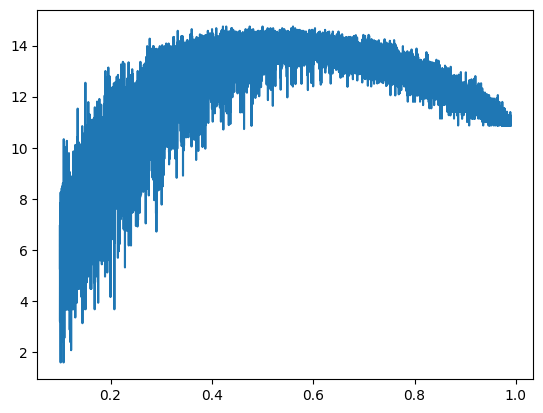

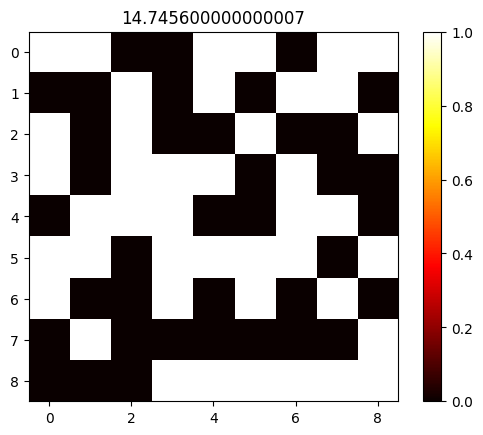

In [84]:
import matplotlib.pyplot as plt

probability_of_success_message = .8
probability_of_success_tag = 1

for i in range(1):

    m_nr,t_nr = 9,9
    p_fill_ks = np.linspace(0.1,0.99,13000)
    As = []
    Ks = []
    for p_fill_k in p_fill_ks:
        k = random_binary_array(shape = (m_nr,t_nr), probability_of_one = p_fill_k)
        m = np.array([probability_of_success_message]*m_nr)
        t = np.array([probability_of_success_tag]*t_nr)
        A = validate(k,m,t)
        L = Latency(k,np.ones(m_nr),np.ones(t_nr))

        As.append(np.sum(A))#- sum(L))
    
        Ks.append(k)

    plt.plot(p_fill_ks,As)
    plt.show()





    plt.imshow(Ks[np.argmax(As)], cmap= 'hot', interpolation='nearest')
    plt.colorbar()
    plt.title('{}'.format(As[np.argmax(As)]))
    plt.show()

